In [75]:
import polars as pl
from src.paths import (
    PYTHON_VULNERABILITY_FIXES_DATA_PATH,
    PYTHON_CODE_FIXES_DATA_PATH,
    PYTHON_CODE_FIXES_WITH_CONTEXT_DATA_PATH,
    PYTHON_CODE_UNITS_DATA_PATH,
    PYTHON_CODE_CONTEXT_DATA_PATH,
)
from tqdm import tqdm
import jedi
from git import Repo
from typing import Any
import jedi.api
import jedi.common
import json
import shutil
import logging
import matplotlib.pyplot as plt
import tempfile
import subprocess
from pathlib import Path
import json

from src.process_code_changes import get_changes

## Filter out data

In [76]:
# python_commit_data = commit_data_only_top_langs.filter(pl.col("language") == "Python")
python_vulnerability_fixes = pl.read_parquet(PYTHON_VULNERABILITY_FIXES_DATA_PATH)
print(python_vulnerability_fixes.unique("vulnerability_id").shape[0])
python_vulnerability_fixes = python_vulnerability_fixes.group_by('vulnerability_id', 'repo', 'commit', 'pull_request_number', 'file', 'patch', 'patch_time', 'commit_source', 'file_extension', 'language').agg(pl.col("cwe_id"))
python_vulnerability_fixes = python_vulnerability_fixes.unique("patch")
print(python_vulnerability_fixes.unique("vulnerability_id").shape[0])


1560
1556


## Filter out data connected with test functionallity

In [77]:
python_vulnerability_fixes = python_vulnerability_fixes.filter(
    (
        pl.col("file").str.contains(r"\/{0,1}[tT][eE][sS][tT][sS]{0,1}\/")
        | pl.col("patch").str.contains("pytest")
        | pl.col("patch").str.contains("unittest")
    ).not_()
)
python_vulnerability_fixes.unique("vulnerability_id").shape[0]

1550

In [78]:
exclude_langs = [
    "txt",
    "md",
    "JSON",
    "YAML",
    "bugfix",
    "cfg",
    "rst",
    "toml",
    "lock",
    "ini",
    "in",
    "gitignore",
    "sample",
    "pem",
    "feature",
    "tif",
    "security",
    "proto",
    "conf",
    "spec",
    "bin",
    "misc",
    "pyi",
    "pxi",
    "fli",
    "gif",
    "tpl",
    "graphql",
    "http",
    "sgi",
    "pyx",
    "inc"
]
python_vulnerability_fixes = python_vulnerability_fixes.filter(
    (
        pl.col("file").str.split(".").list.last().is_in(exclude_langs)
    ).not_(),
    pl.col("file").str.contains(r"__.*__.py").not_()
)
python_vulnerability_fixes.unique("vulnerability_id").shape[0]

1506

## Process missing commit

In [79]:
print(python_vulnerability_fixes.filter(pl.col("commit").is_null()))
python_vulnerability_fixes = python_vulnerability_fixes.with_columns(
    pl.when(pl.col("pull_request_number") == 24391)
    .then(pl.lit("86664c9405136a4904775c52e6caf100a474ec58"))
    .otherwise(pl.col("commit"))
    .alias("commit")
)
print(python_vulnerability_fixes.filter(pl.col("commit").is_null()))
# No changes related to python: https://github.com/pyca/pyopenssl/commit/6bbf44a00b35fb28df1f66aa194b2fe95eab1ab2
# Very big change: https://github.com/transifex/transifex-client/commit/e0d1f8b38ec1a24e2999d63420554d8393206f58
python_vulnerability_fixes = python_vulnerability_fixes.filter(
    ~pl.col("commit").is_in(
        [
            "6bbf44a00b35fb28df1f66aa194b2fe95eab1ab2",
            "e0d1f8b38ec1a24e2999d63420554d8393206f58",
            "5f7496481bd3db1d06a2d2e62c0dce960a1fe12b",
            # Not exists in repo
            "13336272e32872247fa7d17e964ccd88ec8d1376",
            "2bfe358043096fdba9e2a4cf0f5740102b37fd8f",
        ]
    )
)
python_vulnerability_fixes = python_vulnerability_fixes.filter(
    pl.col("file") != "setup.py"
)
print(python_vulnerability_fixes.filter(pl.col("commit").is_null()))

shape: (32, 11)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ vulnerabil ‚îÜ repo       ‚îÜ commit ‚îÜ pull_reque ‚îÜ ‚Ä¶ ‚îÜ commit_so ‚îÜ file_exte ‚îÜ language ‚îÜ cwe_id    ‚îÇ
‚îÇ ity_id     ‚îÜ ---        ‚îÜ ---    ‚îÜ st_number  ‚îÜ   ‚îÜ urce      ‚îÜ nsion     ‚îÜ ---      ‚îÜ ---       ‚îÇ
‚îÇ ---        ‚îÜ str        ‚îÜ str    ‚îÜ ---        ‚îÜ   ‚îÜ ---       ‚îÜ ---       ‚îÜ str      ‚îÜ list[str] ‚îÇ
‚îÇ str        ‚îÜ            ‚îÜ        ‚îÜ i64        ‚îÜ   ‚îÜ str       ‚îÜ str       ‚îÜ          ‚îÜ           ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ï

In [81]:
python_vulnerability_fixes.filter(pl.col("vulnerability_id") == "2022-29198").unique("language")

shape: (1, 11)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ vulnerabi ‚îÜ repo      ‚îÜ commit    ‚îÜ pull_requ ‚îÜ ‚Ä¶ ‚îÜ commit_so ‚îÜ file_exte ‚îÜ language ‚îÜ cwe_id    ‚îÇ
‚îÇ lity_id   ‚îÜ ---       ‚îÜ ---       ‚îÜ est_numbe ‚îÜ   ‚îÜ urce      ‚îÜ nsion     ‚îÜ ---      ‚îÜ ---       ‚îÇ
‚îÇ ---       ‚îÜ str       ‚îÜ str       ‚îÜ r         ‚îÜ   ‚îÜ ---       ‚îÜ ---       ‚îÜ str      ‚îÜ list[str] ‚îÇ
‚îÇ str       ‚îÜ           ‚îÜ           ‚îÜ ---       ‚îÜ   ‚îÜ str       ‚îÜ str       ‚îÜ          ‚îÜ           ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ           ‚îÜ i64       ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ          ‚îÜ           ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 2022-2919 ‚îÜ tensorflo ‚îÜ ea50a40e8 ‚îÜ null      ‚îÜ ‚Ä¶ ‚îÜ github    ‚îÜ cc        ‚îÜ C/C++    ‚îÜ ["CWE-20" ‚îÇ
‚îÇ 8         ‚îÜ w/tensorf ‚îÜ 4f6bff15a ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ          ‚îÜ ]         ‚îÇ
‚îÇ           ‚îÜ low       ‚îÜ 0912728e3 ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ          ‚îÜ           ‚îÇ
‚îÇ           ‚îÜ           ‚îÜ 5b6‚Ä¶      ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ           ‚îÜ          ‚îÜ           ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

In [82]:
if PYTHON_CODE_FIXES_DATA_PATH.exists():
    print("Reading code fixes")
    code_unit_changes = pl.read_parquet(PYTHON_CODE_FIXES_DATA_PATH).to_dicts()
else:
    code_unit_changes: list[dict[str, Any]] = []

repos: dict[str, Repo] = {}

grouped_vulnerabilities = (
    python_vulnerability_fixes.group_by(
        "repo", "vulnerability_id", "commit", "commit_source", "cwe_id"
    )
    .agg(pl.col("patch"), pl.col("file"), pl.col("language"))
    .sample(fraction=1, shuffle=True)
)
errors: list[dict[str, Any]] = []
checked_commits = set([change["commit"] for change in code_unit_changes])


vulnerabilities_to_check = grouped_vulnerabilities.to_dicts()


for commit_data_row in tqdm(vulnerabilities_to_check):
    if commit_data_row["commit"] in checked_commits:
        continue
    try:
        get_changes(commit_data_row)
    except Exception as e:
        logging.exception(f"Error in {commit_data_row}")

Reading code fixes


  0%|          | 0/1800 [00:00<?, ?it/s]ERROR:src.process_code_changes:Error processing commit c4f81d9616d40c60584e36abb15300853a66e489
ERROR:src.process_code_changes:{'repo': 'opengeos/streamlit-geospatial', 'vulnerability_id': '2024-41117', 'commit': 'c4f81d9616d40c60584e36abb15300853a66e489', 'commit_source': 'github', 'cwe_id': ['CWE-20'], 'patch': ['@@ -1,4 +1,5 @@\n import ee\n+import json\n import os\n import warnings\n import datetime\n@@ -377,7 +378,9 @@ def app():\n                         st.write(\n                             cm.plot_colormap(cmap=palette_options, return_fig=True)\n                         )\n-                        st.session_state["palette"] = eval(palette)\n+                        st.session_state["palette"] = json.loads(\n+                            palette.replace("\'", \'"\')\n+                        )\n \n                     if bands:\n                         vis_params = st.text_area(\n@@ -392,7 +395,9 @@ def app():\n                         

In [83]:
new_code_unit_changes = []
new_code_context_changes = []

for commit_data_file in PYTHON_CODE_UNITS_DATA_PATH.rglob("*.json"):
    try:
        with commit_data_file.open() as f:
            new_code_unit_changes.append(json.load(f))
    except:
        print(commit_data_file)
        commit_data_file.unlink()
for commit_data_file in PYTHON_CODE_CONTEXT_DATA_PATH.rglob("*.json"):
    try:
        with commit_data_file.open() as f:
            new_code_context_changes.append(json.load(f))
    except:
        print(commit_data_file)
        commit_data_file.unlink()

pl.DataFrame(new_code_unit_changes).write_parquet(PYTHON_CODE_FIXES_DATA_PATH)
pl.DataFrame(new_code_context_changes).write_parquet(PYTHON_CODE_FIXES_WITH_CONTEXT_DATA_PATH)

In [115]:
pl.read_parquet(PYTHON_CODE_FIXES_DATA_PATH).unique("vulnerability_id").shape[0] / grouped_vulnerabilities.unique("vulnerability_id").shape[0]

1.1140939597315436

## Data cleaning

In [85]:
code_unit_changes_df = pl.read_parquet(PYTHON_CODE_FIXES_DATA_PATH)
code_unit_changes_df = code_unit_changes_df.filter(
    # pl.col("vulnerability_id").is_in(excluded_vulns).not_(),
    pl.col("new_file") != "setup.py",
    pl.col("old_file") != "setup.py"
).with_columns(
    pl.col("code_unit_after_fix").str.replace_all(r"\n\s*\n", "\n").str.strip_chars(),
    pl.col("code_unit_before_fix").str.replace_all(r"\n\s*\n", "\n").str.strip_chars(),
)
code_unit_changes_df.describe()

shape: (9, 10)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ statistic  ‚îÜ commit     ‚îÜ repo      ‚îÜ new_file  ‚îÜ ‚Ä¶ ‚îÜ vulnerabi ‚îÜ cwe_id ‚îÜ old_file  ‚îÜ code_unit ‚îÇ
‚îÇ ---        ‚îÜ ---        ‚îÜ ---       ‚îÜ ---       ‚îÜ   ‚îÜ lity_id   ‚îÜ ---    ‚îÜ ---       ‚îÜ _before_f ‚îÇ
‚îÇ str        ‚îÜ str        ‚îÜ str       ‚îÜ str       ‚îÜ   ‚îÜ ---       ‚îÜ f64    ‚îÜ str       ‚îÜ ix        ‚îÇ
‚îÇ            ‚îÜ            ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ str       ‚îÜ        ‚îÜ           ‚îÜ ---       ‚îÇ
‚îÇ            ‚îÜ            ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ        ‚îÜ           ‚îÜ str       ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ count      ‚îÜ 4401       ‚îÜ 4401      ‚îÜ 4401      ‚îÜ ‚Ä¶ ‚îÜ 4401      ‚îÜ 4401.0 ‚îÜ 4401      ‚îÜ 4401      ‚îÇ
‚îÇ null_count ‚îÜ 0          ‚îÜ 0         ‚îÜ 0         ‚îÜ ‚Ä¶ ‚îÜ 0         ‚îÜ 0.0    ‚îÜ 0         ‚îÜ 0         ‚îÇ
‚îÇ mean       ‚îÜ null       ‚îÜ null      ‚îÜ null      ‚îÜ ‚Ä¶ ‚îÜ null      ‚îÜ null   ‚îÜ null      ‚îÜ null      ‚îÇ
‚îÇ std        ‚îÜ null       ‚îÜ null      ‚îÜ null      ‚îÜ ‚Ä¶ ‚îÜ null      ‚îÜ null   ‚îÜ null      ‚îÜ null      ‚îÇ
‚îÇ min        ‚îÜ 001b0634cd ‚îÜ 389ds/389 ‚îÜ .devconta ‚îÜ ‚Ä¶ ‚îÜ 2013-0208 ‚îÜ null   ‚îÜ .devconta ‚îÜ           ‚îÇ
‚îÇ            ‚îÜ 309e372edb ‚îÜ -ds-base  ‚îÜ iner/libr ‚îÜ   ‚îÜ           ‚îÜ        ‚îÜ iner/libr ‚îÜ           ‚îÇ
‚îÇ            ‚îÜ 6d7d95d083 ‚îÜ           ‚îÜ ary-scrip ‚îÜ   ‚îÜ           ‚îÜ        ‚îÜ ary-scrip ‚îÜ           ‚îÇ
‚îÇ            ‚îÜ ‚Ä¶          ‚îÜ           ‚îÜ ts/‚Ä¶      ‚îÜ   ‚îÜ           ‚îÜ        ‚îÜ ts/‚Ä¶      ‚îÜ           ‚îÇ
‚îÇ 25%        ‚îÜ null       ‚îÜ null      ‚îÜ null      ‚îÜ ‚Ä¶ ‚îÜ null      ‚îÜ null   ‚îÜ null      ‚îÜ null      ‚îÇ
‚îÇ 50%        ‚îÜ null       ‚îÜ null      ‚îÜ null      ‚îÜ ‚Ä¶ ‚îÜ null      ‚îÜ null   ‚îÜ null      ‚îÜ null      ‚îÇ
‚îÇ 75%        ‚îÜ null       ‚îÜ null      ‚îÜ null      ‚îÜ ‚Ä¶ ‚îÜ null      ‚îÜ null   ‚îÜ null      ‚îÜ null      ‚îÇ
‚îÇ max        ‚îÜ ffc095a3e5 ‚îÜ zwczou/we ‚îÜ zproject/ ‚îÜ ‚Ä¶ ‚îÜ GHSA-x563 ‚îÜ null   ‚îÜ zproject/ ‚îÜ },        ‚îÇ
‚îÇ            ‚îÜ acc1c40477 ‚îÜ ixin-pyth ‚îÜ urls.py   ‚îÜ   ‚îÜ -6hqv-26m ‚îÜ        ‚îÜ urls.py   ‚îÜ "scope":  ‚îÇ
‚îÇ            ‚îÜ 3a0510e6d0 ‚îÜ on        ‚îÜ           ‚îÜ   ‚îÜ r         ‚îÜ        ‚îÜ           ‚îÜ {         ‚îÇ
‚îÇ            ‚îÜ ‚Ä¶          ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ        ‚îÜ           ‚îÜ         ‚Ä¶ ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

In [86]:
code_unit_changes_df = code_unit_changes_df.filter(
    ((pl.col("code_unit_after_fix").str.strip_chars() == "") & (pl.col("code_unit_before_fix").str.strip_chars() == "")).not_(), 
)
code_unit_changes_df.describe()

shape: (9, 10)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ statistic  ‚îÜ commit     ‚îÜ repo      ‚îÜ new_file  ‚îÜ ‚Ä¶ ‚îÜ vulnerabi ‚îÜ cwe_id ‚îÜ old_file  ‚îÜ code_unit ‚îÇ
‚îÇ ---        ‚îÜ ---        ‚îÜ ---       ‚îÜ ---       ‚îÜ   ‚îÜ lity_id   ‚îÜ ---    ‚îÜ ---       ‚îÜ _before_f ‚îÇ
‚îÇ str        ‚îÜ str        ‚îÜ str       ‚îÜ str       ‚îÜ   ‚îÜ ---       ‚îÜ f64    ‚îÜ str       ‚îÜ ix        ‚îÇ
‚îÇ            ‚îÜ            ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ str       ‚îÜ        ‚îÜ           ‚îÜ ---       ‚îÇ
‚îÇ            ‚îÜ            ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ        ‚îÜ           ‚îÜ str       ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ count      ‚îÜ 4378       ‚îÜ 4378      ‚îÜ 4378      ‚îÜ ‚Ä¶ ‚îÜ 4378      ‚îÜ 4378.0 ‚îÜ 4378      ‚îÜ 4378      ‚îÇ
‚îÇ null_count ‚îÜ 0          ‚îÜ 0         ‚îÜ 0         ‚îÜ ‚Ä¶ ‚îÜ 0         ‚îÜ 0.0    ‚îÜ 0         ‚îÜ 0         ‚îÇ
‚îÇ mean       ‚îÜ null       ‚îÜ null      ‚îÜ null      ‚îÜ ‚Ä¶ ‚îÜ null      ‚îÜ null   ‚îÜ null      ‚îÜ null      ‚îÇ
‚îÇ std        ‚îÜ null       ‚îÜ null      ‚îÜ null      ‚îÜ ‚Ä¶ ‚îÜ null      ‚îÜ null   ‚îÜ null      ‚îÜ null      ‚îÇ
‚îÇ min        ‚îÜ 001b0634cd ‚îÜ 389ds/389 ‚îÜ .devconta ‚îÜ ‚Ä¶ ‚îÜ 2013-0208 ‚îÜ null   ‚îÜ .devconta ‚îÜ           ‚îÇ
‚îÇ            ‚îÜ 309e372edb ‚îÜ -ds-base  ‚îÜ iner/libr ‚îÜ   ‚îÜ           ‚îÜ        ‚îÜ iner/libr ‚îÜ           ‚îÇ
‚îÇ            ‚îÜ 6d7d95d083 ‚îÜ           ‚îÜ ary-scrip ‚îÜ   ‚îÜ           ‚îÜ        ‚îÜ ary-scrip ‚îÜ           ‚îÇ
‚îÇ            ‚îÜ ‚Ä¶          ‚îÜ           ‚îÜ ts/‚Ä¶      ‚îÜ   ‚îÜ           ‚îÜ        ‚îÜ ts/‚Ä¶      ‚îÜ           ‚îÇ
‚îÇ 25%        ‚îÜ null       ‚îÜ null      ‚îÜ null      ‚îÜ ‚Ä¶ ‚îÜ null      ‚îÜ null   ‚îÜ null      ‚îÜ null      ‚îÇ
‚îÇ 50%        ‚îÜ null       ‚îÜ null      ‚îÜ null      ‚îÜ ‚Ä¶ ‚îÜ null      ‚îÜ null   ‚îÜ null      ‚îÜ null      ‚îÇ
‚îÇ 75%        ‚îÜ null       ‚îÜ null      ‚îÜ null      ‚îÜ ‚Ä¶ ‚îÜ null      ‚îÜ null   ‚îÜ null      ‚îÜ null      ‚îÇ
‚îÇ max        ‚îÜ ffc095a3e5 ‚îÜ zwczou/we ‚îÜ zproject/ ‚îÜ ‚Ä¶ ‚îÜ GHSA-x563 ‚îÜ null   ‚îÜ zproject/ ‚îÜ },        ‚îÇ
‚îÇ            ‚îÜ acc1c40477 ‚îÜ ixin-pyth ‚îÜ urls.py   ‚îÜ   ‚îÜ -6hqv-26m ‚îÜ        ‚îÜ urls.py   ‚îÜ "scope":  ‚îÇ
‚îÇ            ‚îÜ 3a0510e6d0 ‚îÜ on        ‚îÜ           ‚îÜ   ‚îÜ r         ‚îÜ        ‚îÜ           ‚îÜ {         ‚îÇ
‚îÇ            ‚îÜ ‚Ä¶          ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ        ‚îÜ           ‚îÜ         ‚Ä¶ ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

In [87]:
sorted(code_unit_changes_df.with_columns(
    pl.col("new_file").str.split(".").list.last().alias("lang")
).group_by("vulnerability_id").agg("lang").with_columns(pl.col("lang").list.unique()).unique("lang").filter(pl.col("lang").list.contains("py").not_()).select("vulnerability_id").to_series().to_list())

['2018-10861',
 '2018-5729',
 '2020-5224',
 '2021-41104',
 '2022-25882',
 '2022-31116',
 '2022-35999',
 '2022-41893',
 '2023-24817',
 '2023-46249',
 '2023-52266',
 '2023-6507',
 '2024-21485',
 '2024-32979',
 '2024-49377']

### Duplicate code detection

In [88]:
concated_code_units = pl.concat(
    [code_unit_changes_df.filter(pl.col("code_unit_after_fix").str.strip_chars() != "").select(
        pl.col("code_unit_after_fix").alias("code_unit"), pl.col("commit"), pl.col("repo")
    ),
    code_unit_changes_df.filter(pl.col("code_unit_before_fix").str.strip_chars() != "").select(
        pl.col("code_unit_before_fix").alias("code_unit"), pl.col("commit"), pl.col("repo")
    )]
)

print(concated_code_units.group_by("code_unit").agg("commit", "repo").filter(pl.col("commit").list.len() > 1).shape[0])


578


#### Filter duplicates in vulnerability

In [89]:
without_duplicates = code_unit_changes_df.unique(["vulnerability_id", "code_unit_before_fix", "code_unit_after_fix"])
without_duplicates = without_duplicates.filter(
    pl.col("code_unit_after_fix").str.strip_chars() != pl.col("code_unit_before_fix").str.strip_chars()
)
print(without_duplicates.describe())

shape: (9, 10)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ statistic  ‚îÜ commit     ‚îÜ repo      ‚îÜ new_file  ‚îÜ ‚Ä¶ ‚îÜ vulnerabi ‚îÜ cwe_id ‚îÜ old_file  ‚îÜ code_unit ‚îÇ
‚îÇ ---        ‚îÜ ---        ‚îÜ ---       ‚îÜ ---       ‚îÜ   ‚îÜ lity_id   ‚îÜ ---    ‚îÜ ---       ‚îÜ _before_f ‚îÇ
‚îÇ str        ‚îÜ str        ‚îÜ str       ‚îÜ str       ‚îÜ   ‚îÜ ---       ‚îÜ f64    ‚îÜ str       ‚îÜ ix        ‚îÇ
‚îÇ            ‚îÜ            ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ str       ‚îÜ        ‚îÜ           ‚îÜ ---       ‚îÇ
‚îÇ            ‚îÜ            ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ        ‚îÜ           ‚îÜ str       ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï

#### Consistency checks

In [90]:
## Looking for code units that are the same before and after the fix

inconsistent_code_units = without_duplicates.select("vulnerability_id", "code_unit_before_fix").filter(
    pl.col("code_unit_before_fix").str.strip_chars() != ""
).join(
    without_duplicates.select("vulnerability_id", "code_unit_after_fix").filter(
        pl.col("code_unit_after_fix").str.strip_chars() != ""
    ), 
    how="cross"
).filter(pl.col("code_unit_before_fix") == pl.col("code_unit_after_fix"))

inconsistent_code_units

shape: (41, 4)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ vulnerability_id ‚îÜ code_unit_before_fix      ‚îÜ vulnerability_id_right ‚îÜ code_unit_after_fix      ‚îÇ
‚îÇ ---              ‚îÜ ---                       ‚îÜ ---                    ‚îÜ ---                      ‚îÇ
‚îÇ str              ‚îÜ str                       ‚îÜ str                    ‚îÜ str                      ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 2021-36219       ‚îÜ #include                  ‚îÜ 2021-36219             ‚îÜ #include                 ‚îÇ
‚îÇ                  ‚îÜ "SGXWALLET_VERSION"       ‚îÜ                        ‚îÜ "SGXWALLET_VERSION"      ‚îÇ
‚îÇ 2019-14859       ‚îÜ def read_length(string):  ‚îÜ 2019-14859             ‚îÜ def read_length(string): ‚îÇ
‚îÇ                  ‚îÜ     i‚Ä¶                    ‚îÜ                        ‚îÜ     i‚Ä¶                   ‚îÇ
‚îÇ 2020-15142       ‚îÜ def _sanitize(value: str) ‚îÜ 2020-15141             ‚îÜ def _sanitize(value:     ‚îÇ
‚îÇ                  ‚îÜ -> s‚Ä¶                     ‚îÜ                        ‚îÜ str) -> s‚Ä¶               ‚îÇ
‚îÇ 2022-3363        ‚îÜ def get_parser():         ‚îÜ 2022-4018              ‚îÜ def get_parser():        ‚îÇ
‚îÇ                  ‚îÜ     parser =‚Ä¶             ‚îÜ                        ‚îÜ     parser =‚Ä¶            ‚îÇ
‚îÇ 2023-51449       ‚îÜ def                       ‚îÜ 2023-34239             ‚îÜ def                      ‚îÇ
‚îÇ                  ‚îÜ is_in_or_equal(path_1:    ‚îÜ                        ‚îÜ is_in_or_equal(path_1:   ‚îÇ
‚îÇ                  ‚îÜ str‚Ä¶                      ‚îÜ                        ‚îÜ str‚Ä¶                     ‚îÇ
‚îÇ ‚Ä¶                ‚îÜ ‚Ä¶                         ‚îÜ ‚Ä¶                      ‚îÜ ‚Ä¶                        ‚îÇ
‚îÇ 2015-2317        ‚îÜ def is_safe_url(url,      ‚îÜ 2015-0220              ‚îÜ def is_safe_url(url,     ‚îÇ
‚îÇ                  ‚îÜ host=None‚Ä¶                ‚îÜ                        ‚îÜ host=None‚Ä¶               ‚îÇ
‚îÇ 2015-2317        ‚îÜ def is_safe_url(url,      ‚îÜ 2015-0220              ‚îÜ def is_safe_url(url,     ‚îÇ
‚îÇ                  ‚îÜ host=None‚Ä¶                ‚îÜ                        ‚îÜ host=None‚Ä¶               ‚îÇ
‚îÇ 2024-21649       ‚îÜ def serialize(data: any)  ‚îÜ 2023-23930             ‚îÜ def serialize(data: any) ‚îÇ
‚îÇ                  ‚îÜ -> by‚Ä¶                    ‚îÜ                        ‚îÜ -> by‚Ä¶                   ‚îÇ
‚îÇ 2021-41194       ‚îÜ class                     ‚îÜ 2021-41194             ‚îÜ class FirstUseAuthentica ‚îÇ
‚îÇ                  ‚îÜ FirstUseAuthenticator(Au‚Ä¶ ‚îÜ                        ‚îÜ tor(Au‚Ä¶                  ‚îÇ
‚îÇ 2023-24580       ‚îÜ class MultiPartParser:    ‚îÜ 2022-23833             ‚îÜ class MultiPartParser:   ‚îÇ
‚îÇ                  ‚îÜ     def‚Ä¶                  ‚îÜ                        ‚îÜ     def‚Ä¶                 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

#### Fix and check consistency

Usually, there are a few vulnerabilities in code unit. Some of them was fixed later.
There aren't so much bad cases, so we can just drop inconsistent rows

Code examples on right have hidden vulnerability. We can exclude such vulnerabilities from dataset

In [91]:
inconsistent_vulns = set(inconsistent_code_units.select("vulnerability_id_right").to_series().to_list())
consistency_fix_vulnerabilities = without_duplicates.filter(
    pl.col("vulnerability_id").is_in(inconsistent_vulns).not_()
)
consistency_fix_vulnerabilities.describe()

shape: (9, 10)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ statistic  ‚îÜ commit     ‚îÜ repo      ‚îÜ new_file  ‚îÜ ‚Ä¶ ‚îÜ vulnerabi ‚îÜ cwe_id ‚îÜ old_file  ‚îÜ code_unit ‚îÇ
‚îÇ ---        ‚îÜ ---        ‚îÜ ---       ‚îÜ ---       ‚îÜ   ‚îÜ lity_id   ‚îÜ ---    ‚îÜ ---       ‚îÜ _before_f ‚îÇ
‚îÇ str        ‚îÜ str        ‚îÜ str       ‚îÜ str       ‚îÜ   ‚îÜ ---       ‚îÜ f64    ‚îÜ str       ‚îÜ ix        ‚îÇ
‚îÇ            ‚îÜ            ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ str       ‚îÜ        ‚îÜ           ‚îÜ ---       ‚îÇ
‚îÇ            ‚îÜ            ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ        ‚îÜ           ‚îÜ str       ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ count      ‚îÜ 3604       ‚îÜ 3604      ‚îÜ 3604      ‚îÜ ‚Ä¶ ‚îÜ 3604      ‚îÜ 3604.0 ‚îÜ 3604      ‚îÜ 3604      ‚îÇ
‚îÇ null_count ‚îÜ 0          ‚îÜ 0         ‚îÜ 0         ‚îÜ ‚Ä¶ ‚îÜ 0         ‚îÜ 0.0    ‚îÜ 0         ‚îÜ 0         ‚îÇ
‚îÇ mean       ‚îÜ null       ‚îÜ null      ‚îÜ null      ‚îÜ ‚Ä¶ ‚îÜ null      ‚îÜ null   ‚îÜ null      ‚îÜ null      ‚îÇ
‚îÇ std        ‚îÜ null       ‚îÜ null      ‚îÜ null      ‚îÜ ‚Ä¶ ‚îÜ null      ‚îÜ null   ‚îÜ null      ‚îÜ null      ‚îÇ
‚îÇ min        ‚îÜ 001b0634cd ‚îÜ 389ds/389 ‚îÜ .devconta ‚îÜ ‚Ä¶ ‚îÜ 2013-0208 ‚îÜ null   ‚îÜ .devconta ‚îÜ           ‚îÇ
‚îÇ            ‚îÜ 309e372edb ‚îÜ -ds-base  ‚îÜ iner/libr ‚îÜ   ‚îÜ           ‚îÜ        ‚îÜ iner/libr ‚îÜ           ‚îÇ
‚îÇ            ‚îÜ 6d7d95d083 ‚îÜ           ‚îÜ ary-scrip ‚îÜ   ‚îÜ           ‚îÜ        ‚îÜ ary-scrip ‚îÜ           ‚îÇ
‚îÇ            ‚îÜ ‚Ä¶          ‚îÜ           ‚îÜ ts/‚Ä¶      ‚îÜ   ‚îÜ           ‚îÜ        ‚îÜ ts/‚Ä¶      ‚îÜ           ‚îÇ
‚îÇ 25%        ‚îÜ null       ‚îÜ null      ‚îÜ null      ‚îÜ ‚Ä¶ ‚îÜ null      ‚îÜ null   ‚îÜ null      ‚îÜ null      ‚îÇ
‚îÇ 50%        ‚îÜ null       ‚îÜ null      ‚îÜ null      ‚îÜ ‚Ä¶ ‚îÜ null      ‚îÜ null   ‚îÜ null      ‚îÜ null      ‚îÇ
‚îÇ 75%        ‚îÜ null       ‚îÜ null      ‚îÜ null      ‚îÜ ‚Ä¶ ‚îÜ null      ‚îÜ null   ‚îÜ null      ‚îÜ null      ‚îÇ
‚îÇ max        ‚îÜ ffc095a3e5 ‚îÜ zwczou/we ‚îÜ zproject/ ‚îÜ ‚Ä¶ ‚îÜ GHSA-x563 ‚îÜ null   ‚îÜ zproject/ ‚îÜ },        ‚îÇ
‚îÇ            ‚îÜ acc1c40477 ‚îÜ ixin-pyth ‚îÜ urls.py   ‚îÜ   ‚îÜ -6hqv-26m ‚îÜ        ‚îÜ urls.py   ‚îÜ "scope":  ‚îÇ
‚îÇ            ‚îÜ 3a0510e6d0 ‚îÜ on        ‚îÜ           ‚îÜ   ‚îÜ r         ‚îÜ        ‚îÜ           ‚îÜ {         ‚îÇ
‚îÇ            ‚îÜ ‚Ä¶          ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ        ‚îÜ           ‚îÜ         ‚Ä¶ ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

In [92]:
consistency_fix_vulnerabilities.select("vulnerability_id", "code_unit_before_fix").filter(
    pl.col("code_unit_before_fix").str.strip_chars() != ""
).join(
    consistency_fix_vulnerabilities.select("vulnerability_id", "code_unit_after_fix").filter(
        pl.col("code_unit_after_fix").str.strip_chars() != ""
    ), 
    how="cross"
).filter(pl.col("code_unit_before_fix") == pl.col("code_unit_after_fix")).shape[0]

0

### Advanced filtering with duplicate searcher tool

In [93]:
slice_data = without_duplicates.slice(offset=0, length=100)

with tempfile.TemporaryDirectory() as temp_dir:
    for row in slice_data.iter_rows(named=True):
        path = Path(f"{temp_dir}/new_data/{row['commit']}/{row['new_file']}")
        path.parent.mkdir(parents=True, exist_ok=True)
        with open(path, "w") as f:
            f.write(row["code_unit_after_fix"])
            
        path = Path(f"{temp_dir}/old_data/{row['commit']}/{row['old_file']}")
        path.parent.mkdir(parents=True, exist_ok=True)
        with open(path, "w") as f:
            f.write(row["code_unit_before_fix"])

    similarity = json.loads(subprocess.getoutput(
        "cd /Users/somen/Zavodi/unik/duplicate-code-detection-tool/ && "
        "source .venv/bin/activate && "
        f"python -W ignore duplicate_code_detection.py --json True --file-extensions py -d {temp_dir}/new_data/ {temp_dir}/old_data/",
    ))

SIMILARITY_DATA_PATH = Path("data/similarity.json")
SIMILARITY_DATA_PATH.write_text(json.dumps(similarity))

4252202

In [94]:
similarity = json.loads(SIMILARITY_DATA_PATH.read_text())
similarity = pl.DataFrame(
    [
        {
            "path_1": left_path, 
            "path_2": right_path, 
            "similarity": value
        }  
        for left_path, values in similarity.items() for right_path, value in values.items()
    ]
)
similarity = similarity.with_columns(
    # THIS LINES ARE NOT CROSS PLATFORM. Change index in .get(...) call accordingly to your own path
    pl.col("path_1").str.split("/").list.get(8).alias("commit_1"), 
    pl.col("path_1").str.split("/").list.slice(9).list.join("/").alias("file_path_1"), 
    (pl.col("path_1").str.split("/").list.get(7) == "new_data").alias("is_new_1"),
    pl.col("path_2").str.split("/").list.get(8).alias("commit_2"),
    pl.col("path_2").str.split("/").list.slice(9).list.join("/").alias("file_path_2"),
    (pl.col("path_2").str.split("/").list.get(7) == "new_data").alias("is_new_2"),
)

similarity.describe()

shape: (9, 10)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ statistic  ‚îÜ path_1    ‚îÜ path_2    ‚îÜ similarit ‚îÜ ‚Ä¶ ‚îÜ is_new_1 ‚îÜ commit_2  ‚îÜ file_path ‚îÜ is_new_2 ‚îÇ
‚îÇ ---        ‚îÜ ---       ‚îÜ ---       ‚îÜ y         ‚îÜ   ‚îÜ ---      ‚îÜ ---       ‚îÜ _2        ‚îÜ ---      ‚îÇ
‚îÇ str        ‚îÜ str       ‚îÜ str       ‚îÜ ---       ‚îÜ   ‚îÜ f64      ‚îÜ str       ‚îÜ ---       ‚îÜ f64      ‚îÇ
‚îÇ            ‚îÜ           ‚îÜ           ‚îÜ f64       ‚îÜ   ‚îÜ          ‚îÜ           ‚îÜ str       ‚îÜ          ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ count      ‚îÜ 28056     ‚îÜ 28056     ‚îÜ 28056.0   ‚îÜ ‚Ä¶ ‚îÜ 28056.0  ‚îÜ 28056     ‚îÜ 28056     ‚îÜ 28056.0  ‚îÇ
‚îÇ null_count ‚îÜ 0         ‚îÜ 0         ‚îÜ 0.0       ‚îÜ ‚Ä¶ ‚îÜ 0.0      ‚îÜ 0         ‚îÜ 0         ‚îÜ 0.0      ‚îÇ
‚îÇ mean       ‚îÜ null      ‚îÜ null      ‚îÜ 2.466187  ‚îÜ ‚Ä¶ ‚îÜ 0.5      ‚îÜ null      ‚îÜ null      ‚îÜ 0.5      ‚îÇ
‚îÇ std        ‚îÜ null      ‚îÜ null      ‚îÜ 6.643144  ‚îÜ ‚Ä¶ ‚îÜ null     ‚îÜ null      ‚îÜ null      ‚îÜ null     ‚îÇ
‚îÇ min        ‚îÜ /var/fold ‚îÜ /var/fold ‚îÜ 0.0       ‚îÜ ‚Ä¶ ‚îÜ 0.0      ‚îÜ 0bdcf656d ‚îÜ Calendari ‚îÜ 0.0      ‚îÇ
‚îÇ            ‚îÜ ers/cy/xk ‚îÜ ers/cy/xk ‚îÜ           ‚îÜ   ‚îÜ          ‚îÜ 469e5f675 ‚îÜ nhoApp/au ‚îÜ          ‚îÇ
‚îÇ            ‚îÜ clg4xd0gj ‚îÜ clg4xd0gj ‚îÜ           ‚îÜ   ‚îÜ          ‚îÜ cb56fd644 ‚îÜ thenticat ‚îÜ          ‚îÇ
‚îÇ            ‚îÜ glf‚Ä¶      ‚îÜ glf‚Ä¶      ‚îÜ           ‚îÜ   ‚îÜ          ‚îÜ d82‚Ä¶      ‚îÜ ion‚Ä¶      ‚îÜ          ‚îÇ
‚îÇ 25%        ‚îÜ null      ‚îÜ null      ‚îÜ 0.41      ‚îÜ ‚Ä¶ ‚îÜ null     ‚îÜ null      ‚îÜ null      ‚îÜ null     ‚îÇ
‚îÇ 50%        ‚îÜ null      ‚îÜ null      ‚îÜ 1.38      ‚îÜ ‚Ä¶ ‚îÜ null     ‚îÜ null      ‚îÜ null      ‚îÜ null     ‚îÇ
‚îÇ 75%        ‚îÜ null      ‚îÜ null      ‚îÜ 2.87      ‚îÜ ‚Ä¶ ‚îÜ null     ‚îÜ null      ‚îÜ null      ‚îÜ null     ‚îÇ
‚îÇ max        ‚îÜ /var/fold ‚îÜ /var/fold ‚îÜ 100.0     ‚îÜ ‚Ä¶ ‚îÜ 1.0      ‚îÜ fab24457b ‚îÜ zerver/vi ‚îÜ 1.0      ‚îÇ
‚îÇ            ‚îÜ ers/cy/xk ‚îÜ ers/cy/xk ‚îÜ           ‚îÜ   ‚îÜ          ‚îÜ cf8ede882 ‚îÜ ews/regis ‚îÜ          ‚îÇ
‚îÇ            ‚îÜ clg4xd0gj ‚îÜ clg4xd0gj ‚îÜ           ‚îÜ   ‚îÜ          ‚îÜ abd114197 ‚îÜ tration.p ‚îÜ          ‚îÇ
‚îÇ            ‚îÜ glf‚Ä¶      ‚îÜ glf‚Ä¶      ‚îÜ           ‚îÜ   ‚îÜ          ‚îÜ 69c‚Ä¶      ‚îÜ y         ‚îÜ          ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

#### Checking for duplicates

In [95]:
print(similarity.filter(
    (pl.col("is_new_1").and_(pl.col("is_new_2"))).or_(pl.col("is_new_1").not_().and_(pl.col("is_new_2").not_())), 
    pl.col("commit_1") != pl.col("commit_2")
).filter(pl.col("similarity") > 50).with_columns(
    pl.col("similarity").cast(pl.Int64)
).group_by("similarity").agg(pl.len()))


shape: (3, 2)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ similarity ‚îÜ len ‚îÇ
‚îÇ ---        ‚îÜ --- ‚îÇ
‚îÇ i64        ‚îÜ u32 ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 84         ‚îÜ 2   ‚îÇ
‚îÇ 54         ‚îÜ 2   ‚îÇ
‚îÇ 82         ‚îÜ 2   ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò


In [96]:
similarity.filter(
    (pl.col("is_new_1").and_(pl.col("is_new_2"))).or_(pl.col("is_new_1").not_().and_(pl.col("is_new_2").not_())), 
    pl.col("commit_1") != pl.col("commit_2")
).filter(pl.col("similarity") > 50)

shape: (6, 9)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ path_1     ‚îÜ path_2    ‚îÜ similarit ‚îÜ commit_1  ‚îÜ ‚Ä¶ ‚îÜ is_new_1 ‚îÜ commit_2  ‚îÜ file_path ‚îÜ is_new_2 ‚îÇ
‚îÇ ---        ‚îÜ ---       ‚îÜ y         ‚îÜ ---       ‚îÜ   ‚îÜ ---      ‚îÜ ---       ‚îÜ _2        ‚îÜ ---      ‚îÇ
‚îÇ str        ‚îÜ str       ‚îÜ ---       ‚îÜ str       ‚îÜ   ‚îÜ bool     ‚îÜ str       ‚îÜ ---       ‚îÜ bool     ‚îÇ
‚îÇ            ‚îÜ           ‚îÜ f64       ‚îÜ           ‚îÜ   ‚îÜ          ‚îÜ           ‚îÜ str       ‚îÜ          ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ /var/folde ‚îÜ /var/fold ‚îÜ 54.58     ‚îÜ 2fcb49988 ‚îÜ ‚Ä¶ ‚îÜ true     ‚îÜ ee98e5af7 ‚îÜ rdiffweb/ ‚îÜ true     ‚îÇ
‚îÇ rs/cy/xkcl ‚îÜ ers/cy/xk ‚îÜ           ‚îÜ 87959b4fa ‚îÜ   ‚îÜ          ‚îÜ 8ec60db8a ‚îÜ core/conf ‚îÜ          ‚îÇ
‚îÇ g4xd0gjglf ‚îÜ clg4xd0gj ‚îÜ           ‚îÜ 11894a068 ‚îÜ   ‚îÜ          ‚îÜ 17fef6ea0 ‚îÜ ig.py     ‚îÜ          ‚îÇ
‚îÇ ‚Ä¶          ‚îÜ glf‚Ä¶      ‚îÜ           ‚îÜ d68‚Ä¶      ‚îÜ   ‚îÜ          ‚îÜ ca2‚Ä¶      ‚îÜ           ‚îÜ          ‚îÇ
‚îÇ /var/folde ‚îÜ /var/fold ‚îÜ 82.92     ‚îÜ 960d736e5 ‚îÜ ‚Ä¶ ‚îÜ true     ‚îÜ a014ef75a ‚îÜ zerver/vi ‚îÜ true     ‚îÇ
‚îÇ rs/cy/xkcl ‚îÜ ers/cy/xk ‚îÜ           ‚îÜ 5cbb9386a ‚îÜ   ‚îÜ          ‚îÜ 3a0ed7f24 ‚îÜ ews/regis ‚îÜ          ‚îÇ
‚îÇ g4xd0gjglf ‚îÜ clg4xd0gj ‚îÜ           ‚îÜ 68e4ee45f ‚îÜ   ‚îÜ          ‚îÜ ebb157632 ‚îÜ tration.p ‚îÜ          ‚îÇ
‚îÇ ‚Ä¶          ‚îÜ glf‚Ä¶      ‚îÜ           ‚îÜ 805‚Ä¶      ‚îÜ   ‚îÜ          ‚îÜ ba5‚Ä¶      ‚îÜ y         ‚îÜ          ‚îÇ
‚îÇ /var/folde ‚îÜ /var/fold ‚îÜ 82.92     ‚îÜ a014ef75a ‚îÜ ‚Ä¶ ‚îÜ true     ‚îÜ 960d736e5 ‚îÜ zerver/vi ‚îÜ true     ‚îÇ
‚îÇ rs/cy/xkcl ‚îÜ ers/cy/xk ‚îÜ           ‚îÜ 3a0ed7f24 ‚îÜ   ‚îÜ          ‚îÜ 5cbb9386a ‚îÜ ews/regis ‚îÜ          ‚îÇ
‚îÇ g4xd0gjglf ‚îÜ clg4xd0gj ‚îÜ           ‚îÜ ebb157632 ‚îÜ   ‚îÜ          ‚îÜ 68e4ee45f ‚îÜ tration.p ‚îÜ          ‚îÇ
‚îÇ ‚Ä¶          ‚îÜ glf‚Ä¶      ‚îÜ           ‚îÜ ba5‚Ä¶      ‚îÜ   ‚îÜ          ‚îÜ 805‚Ä¶      ‚îÜ y         ‚îÜ          ‚îÇ
‚îÇ /var/folde ‚îÜ /var/fold ‚îÜ 54.58     ‚îÜ ee98e5af7 ‚îÜ ‚Ä¶ ‚îÜ true     ‚îÜ 2fcb49988 ‚îÜ src/deplo ‚îÜ true     ‚îÇ
‚îÇ rs/cy/xkcl ‚îÜ ers/cy/xk ‚îÜ           ‚îÜ 8ec60db8a ‚îÜ   ‚îÜ          ‚îÜ 87959b4fa ‚îÜ yment/dep ‚îÜ          ‚îÇ
‚îÇ g4xd0gjglf ‚îÜ clg4xd0gj ‚îÜ           ‚îÜ 17fef6ea0 ‚îÜ   ‚îÜ          ‚îÜ 11894a068 ‚îÜ loy.py    ‚îÜ          ‚îÇ
‚îÇ ‚Ä¶          ‚îÜ glf‚Ä¶      ‚îÜ           ‚îÜ ca2‚Ä¶      ‚îÜ   ‚îÜ          ‚îÜ d68‚Ä¶      ‚îÜ           ‚îÜ          ‚îÇ
‚îÇ /var/folde ‚îÜ /var/fold ‚îÜ 84.39     ‚îÜ 960d736e5 ‚îÜ ‚Ä¶ ‚îÜ false    ‚îÜ a014ef75a ‚îÜ zerver/vi ‚îÜ false    ‚îÇ
‚îÇ rs/cy/xkcl ‚îÜ ers/cy/xk ‚îÜ           ‚îÜ 5cbb9386a ‚îÜ   ‚îÜ          ‚îÜ 3a0ed7f24 ‚îÜ ews/regis ‚îÜ          ‚îÇ
‚îÇ g4xd0gjglf ‚îÜ clg4xd0gj ‚îÜ           ‚îÜ 68e4ee45f ‚îÜ   ‚îÜ          ‚îÜ ebb157632 ‚îÜ tration.p ‚îÜ          ‚îÇ
‚îÇ ‚Ä¶          ‚îÜ glf‚Ä¶      ‚îÜ           ‚îÜ 805‚Ä¶      ‚îÜ   ‚îÜ          ‚îÜ ba5‚Ä¶      ‚îÜ y         ‚îÜ          ‚îÇ
‚îÇ /var/folde ‚îÜ /var/fold ‚îÜ 84.39     ‚îÜ a014ef75a ‚îÜ ‚Ä¶ ‚îÜ false    ‚îÜ 960d736e5 ‚îÜ zerver/vi ‚îÜ false    ‚îÇ
‚îÇ rs/cy/xkcl ‚îÜ ers/cy/xk ‚îÜ           ‚îÜ 3a0ed7f24 ‚îÜ   ‚îÜ          ‚îÜ 5cbb9386a ‚îÜ ews/regis ‚îÜ          ‚îÇ
‚îÇ g4xd0gjglf ‚îÜ clg4xd0gj ‚îÜ           ‚îÜ ebb157632 ‚îÜ   ‚îÜ          ‚îÜ 68e4ee45f ‚îÜ tration.p ‚îÜ          ‚îÇ
‚îÇ ‚Ä¶          ‚îÜ glf‚Ä¶      ‚îÜ           ‚îÜ ba5‚Ä¶      

#### Filter out duplicates

In [97]:
commits_to_exclude: set[str] = {
    # Duplicate with 800828887a0509ad1162d6d407e94d8de7eafc60
    "2c09e68ec911919360d5f8502cefc312f9e03c5d",
    # duplicate with e1592e0f26302e79856cc7f2218ae848ae19b0f6
    "4cb35b384ceef52123fc66411a73c36a706825e1",
    # Consistency error with accff72ecc2f6cf5a76d9570198a93ac7c90270e
    "01220354d389cd05474713f8c982d05c9b17aafb",
    "644124ecd0b6e417c527191f866daa05a5a2056d",
    "40b6d1605814dd1db0a46e202d6e56f2e4c9a468"
    # Duplicate with 9f75e2e562fa0c0482f3dde6fc7399a9070b4a3d
    "f27c38ab5d90f68c9dd60cabef248a570c0be8fc",
    # Duplicate with 3dfb8e81bb5f776a6b00c7a90dd087e85b71f8bb
    "3dfb8e81bb5f776a6b00c7a90dd087e85b71f8bb",
    # Duplicate with cc82d986c40328d4ae81298a9d287c95a6326bb0
    "d74a1b1d1325af2a24848044cf2858987f5a3ecc",
    # Duplicate with f50cc0b8cb399bb7b7c1ad23b94c9404f0cc6d23
    "b618339c321c387230d3ea523e80ad47af3de5cf",
    # Duplicate with 03daf774d0d80fb7235910ed1c2b4fbcaebdfe65
    "3b6de811abea0a811e03e3029222a7e459922892",
    # Duplicate with 70e83e72b43e05e57eb42a6d52d01a4d9768f510
    "2936b80dbbc7efb889934aeec80f6142c10266ce",
    # Duplicate with https://github.com/apache/airflow/commit/1cbb0ad26dd17f218c6ab1c2ae59b262c443a443
    "09be0c5c7e847dda1d0be5776f8d5e327ff2281a",
    # Duplicate with 24f43aac0f4116b3d89fdbe973ba92c6cfb0d998
    "54b02d9f3a94de94e4fb471908b8cf798e62e411",
    # Duplicate with fa0d4829f9c81eefb37cc058e2fa1b6a918741da
    "ab2a5d82b4ee3c909d2456704388ccf90e367c9b",
    # Duplicate with de4466d88b816437fb29eff5ab23b9b964cd3985
    "32a7b713468161282f2ea01d5e2faff980d924cd",
    # Duplicate with 813de2672bd7361e9a453ab62cd6e52f96b6525b
    "7b7b909579c8311c140c89b8a9431bf537febf93",
    # Strange commit, no useful info
    "31cb25adecba930bdeee4556709f5a1c42d88fd6",
    # Duplicate with https://github.com/django/django/commit/8cc41ce7a7a8f6bebfdd89d5ab276cd0109f4fc5
    "2f5485346ee6f84b4e52068c04e043092daf55f7",
    # Duplicate with https://github.com/django/django/commit/f27c38ab5d90f68c9dd60cabef248a570c0be8fc
    "9f75e2e562fa0c0482f3dde6fc7399a9070b4a3d",
}

without_duplicates = without_duplicates.filter(
    pl.col("commit").is_in(commits_to_exclude).not_()
) 

#### Checking for consistency

In [98]:
## Looking for code units that are the same before and after the fix
print(similarity.filter(
    pl.col("is_new_1").not_(), pl.col("is_new_2"), pl.col("commit_1") != pl.col("commit_2")
).filter(pl.col("similarity") > 50).with_columns(
    pl.col("similarity").cast(pl.Int64)
).group_by("similarity").agg(pl.len()))


shape: (4, 2)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ similarity ‚îÜ len ‚îÇ
‚îÇ ---        ‚îÜ --- ‚îÇ
‚îÇ i64        ‚îÜ u32 ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 54         ‚îÜ 1   ‚îÇ
‚îÇ 58         ‚îÜ 1   ‚îÇ
‚îÇ 84         ‚îÜ 1   ‚îÇ
‚îÇ 82         ‚îÜ 1   ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò


In [99]:
concated_code_units = pl.concat(
    [without_duplicates.filter(pl.col("code_unit_after_fix").str.strip_chars() != "").select(
        pl.col("code_unit_after_fix").alias("code_unit"), pl.col("commit"), pl.col("repo"), pl.col("vulnerability_id"), pl.col("cwe_id")
    ),
    without_duplicates.filter(pl.col("code_unit_before_fix").str.strip_chars() != "").select(
        pl.col("code_unit_before_fix").alias("code_unit"), pl.col("commit"), pl.col("repo"), pl.col("vulnerability_id"), pl.col("cwe_id")
    )]
)

duplicate_code_units = concated_code_units.group_by("code_unit").agg("commit", "repo", "vulnerability_id", "cwe_id").filter(pl.col("commit").list.len() > 1).sort("repo").slice(2)
set(duplicate_code_units.select("cwe_id").explode("cwe_id").explode("cwe_id").to_series().to_list())


{'CWE-130',
 'CWE-131',
 'CWE-1333',
 'CWE-190',
 'CWE-20',
 'CWE-200',
 'CWE-22',
 'CWE-276',
 'CWE-284',
 'CWE-287',
 'CWE-29',
 'CWE-290',
 'CWE-295',
 'CWE-306',
 'CWE-347',
 'CWE-352',
 'CWE-400',
 'CWE-444',
 'CWE-476',
 'CWE-502',
 'CWE-521',
 'CWE-522',
 'CWE-552',
 'CWE-59',
 'CWE-601',
 'CWE-611',
 'CWE-613',
 'CWE-667',
 'CWE-74',
 'CWE-77',
 'CWE-770',
 'CWE-78',
 'CWE-787',
 'CWE-79',
 'CWE-824',
 'CWE-835',
 'CWE-840',
 'CWE-89',
 'CWE-918',
 'CWE-94',
 None}

In [100]:
def try_convert_to_python3(code: str) -> str:
    try:
        with tempfile.TemporaryFile("w") as temp_file:
            temp_file.write(code)
            temp_file.seek(0)
            
            os.system(f"2to3 -w {temp_file.name}")
            return temp_file.readlines()
    except:
        return code
    


total = 0
errors_count = 0
bad_commits = set()
for row in without_duplicates.sample(fraction=1, shuffle=True).iter_rows(named=True):
    file_extension = row["new_file"].split(".")[-1]
    if file_extension in {"py", "pyi", "pyx", "pxi"}:
        total += 1
        script = jedi.Script(code=row["code_unit_after_fix"])
        errors = script.get_syntax_errors()
        if errors and row["commit"]:
        #     try_convert_to_python3(row["code_unit_after_fix"])
            # # shutil.rmtree(PYTHON_CODE_UNITS_DATA_PATH / row["commit"], ignore_errors=True)
            # # shutil.rmtree(PYTHON_CODE_CONTEXT_DATA_PATH / row["commit"], ignore_errors=True)
            # print(row["vulnerability_id"], row["repo"], row["new_file"], row["commit"])
            # print(row["code_unit_after_fix"])
            # print(errors)
            # break
            bad_commits.add(row["commit"])
            errors_count += 1

print(errors_count, total)

42 3109


In [101]:
without_duplicates.describe()

shape: (9, 10)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ statistic  ‚îÜ commit     ‚îÜ repo      ‚îÜ new_file  ‚îÜ ‚Ä¶ ‚îÜ vulnerabi ‚îÜ cwe_id ‚îÜ old_file  ‚îÜ code_unit ‚îÇ
‚îÇ ---        ‚îÜ ---        ‚îÜ ---       ‚îÜ ---       ‚îÜ   ‚îÜ lity_id   ‚îÜ ---    ‚îÜ ---       ‚îÜ _before_f ‚îÇ
‚îÇ str        ‚îÜ str        ‚îÜ str       ‚îÜ str       ‚îÜ   ‚îÜ ---       ‚îÜ f64    ‚îÜ str       ‚îÜ ix        ‚îÇ
‚îÇ            ‚îÜ            ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ str       ‚îÜ        ‚îÜ           ‚îÜ ---       ‚îÇ
‚îÇ            ‚îÜ            ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ        ‚îÜ           ‚îÜ str       ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ count      ‚îÜ 3716       ‚îÜ 3716      ‚îÜ 3716      ‚îÜ ‚Ä¶ ‚îÜ 3716      ‚îÜ 3716.0 ‚îÜ 3716      ‚îÜ 3716      ‚îÇ
‚îÇ null_count ‚îÜ 0          ‚îÜ 0         ‚îÜ 0         ‚îÜ ‚Ä¶ ‚îÜ 0         ‚îÜ 0.0    ‚îÜ 0         ‚îÜ 0         ‚îÇ
‚îÇ mean       ‚îÜ null       ‚îÜ null      ‚îÜ null      ‚îÜ ‚Ä¶ ‚îÜ null      ‚îÜ null   ‚îÜ null      ‚îÜ null      ‚îÇ
‚îÇ std        ‚îÜ null       ‚îÜ null      ‚îÜ null      ‚îÜ ‚Ä¶ ‚îÜ null      ‚îÜ null   ‚îÜ null      ‚îÜ null      ‚îÇ
‚îÇ min        ‚îÜ 001b0634cd ‚îÜ 389ds/389 ‚îÜ .devconta ‚îÜ ‚Ä¶ ‚îÜ 2013-0208 ‚îÜ null   ‚îÜ .devconta ‚îÜ           ‚îÇ
‚îÇ            ‚îÜ 309e372edb ‚îÜ -ds-base  ‚îÜ iner/libr ‚îÜ   ‚îÜ           ‚îÜ        ‚îÜ iner/libr ‚îÜ           ‚îÇ
‚îÇ            ‚îÜ 6d7d95d083 ‚îÜ           ‚îÜ ary-scrip ‚îÜ   ‚îÜ           ‚îÜ        ‚îÜ ary-scrip ‚îÜ           ‚îÇ
‚îÇ            ‚îÜ ‚Ä¶          ‚îÜ           ‚îÜ ts/‚Ä¶      ‚îÜ   ‚îÜ           ‚îÜ        ‚îÜ ts/‚Ä¶      ‚îÜ           ‚îÇ
‚îÇ 25%        ‚îÜ null       ‚îÜ null      ‚îÜ null      ‚îÜ ‚Ä¶ ‚îÜ null      ‚îÜ null   ‚îÜ null      ‚îÜ null      ‚îÇ
‚îÇ 50%        ‚îÜ null       ‚îÜ null      ‚îÜ null      ‚îÜ ‚Ä¶ ‚îÜ null      ‚îÜ null   ‚îÜ null      ‚îÜ null      ‚îÇ
‚îÇ 75%        ‚îÜ null       ‚îÜ null      ‚îÜ null      ‚îÜ ‚Ä¶ ‚îÜ null      ‚îÜ null   ‚îÜ null      ‚îÜ null      ‚îÇ
‚îÇ max        ‚îÜ ffc095a3e5 ‚îÜ zwczou/we ‚îÜ zproject/ ‚îÜ ‚Ä¶ ‚îÜ GHSA-x563 ‚îÜ null   ‚îÜ zproject/ ‚îÜ },        ‚îÇ
‚îÇ            ‚îÜ acc1c40477 ‚îÜ ixin-pyth ‚îÜ urls.py   ‚îÜ   ‚îÜ -6hqv-26m ‚îÜ        ‚îÜ urls.py   ‚îÜ "scope":  ‚îÇ
‚îÇ            ‚îÜ 3a0510e6d0 ‚îÜ on        ‚îÜ           ‚îÜ   ‚îÜ r         ‚îÜ        ‚îÜ           ‚îÜ {         ‚îÇ
‚îÇ            ‚îÜ ‚Ä¶          ‚îÜ           ‚îÜ           ‚îÜ   ‚îÜ           ‚îÜ        ‚îÜ           ‚îÜ         ‚Ä¶ ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

### Dataset balancing

In [ ]:
print(without_duplicates.select("cwe_id").explode("cwe_id").to_series().value_counts().sort("count", descending=True).filter(pl.col("count") < 200).to_dicts())

VULNERABILITY_TYPES_MAPPING = {
    "CWE-770": "CWE-400",
    "CWE-405": "CWE-400",
    "CWE-407": "CWE-400",
    "CWE-1333": "CWE-400",
    # "CWE-920": "CWE-400",
    "CWE-639": "CWE-863",
    "CWE-256": "CWE-1390",
    "CWE-262": "CWE-1390",
    "CWE-263": "CWE-1390",
    "CWE-289": "CWE-1390",
    "CWE-290": "CWE-1390",
    "CWE-294": "CWE-1390",
    "CWE-295": "CWE-1390",
    "CWE-301": "CWE-1390",
    "CWE-302": "CWE-1390",
    "CWE-303": "CWE-1390",
    "CWE-304": "CWE-1390",
    "CWE-305": "CWE-1390",
    "CWE-306": "CWE-1390",
    "CWE-307": "CWE-1390",
    "CWE-308": "CWE-1390",
    "CWE-309": "CWE-1390",
    "CWE-312": "CWE-1390",
    "CWE-324": "CWE-1390",
    "CWE-521": "CWE-1390",
    "CWE-522": "CWE-1390",
    "CWE-593": "CWE-1390",
    "CWE-603": "CWE-1390",
    "CWE-620": "CWE-1390",
    "CWE-640": "CWE-1390",
    "CWE-798": "CWE-1390",
    "CWE-804": "CWE-1390",
    "CWE-836": "CWE-1390",
    "CWE-1391": "CWE-1390",
    "CWE-77": "CWE-74",
    "CWE-78": "CWE-74",
    # "CWE-88": "CWE-74",
    "CWE-89": "CWE-74",
    # "CWE-91": "CWE-74",
    "CWE-94": "CWE-74",
    # "CWE-917": "CWE-74",
    # "CWE-1236": "CWE-74",
    # "CWE-384": "CWE-610",
    "CWE-601": "CWE-610",
    "CWE-611": "CWE-610",
    "CWE-918": "CWE-610",
    # "CWE-1021": "CWE-610",
    # "CWE-532": "CWE-200",
    "CWE-203": "CWE-200",
    "CWE-208": "CWE-200",
    # "CWE-209": "CWE-200",
    "CWE-532": "CWE-200",
    "CWE-470": "CWE-913",
    "CWE-502": "CWE-913",
    "CWE-1321": "CWE-913",
    "CWE-346": "CWE-345",
    "CWE-347": "CWE-345",
    "CWE-348": "CWE-345",
    "CWE-349": "CWE-345",
    "CWE-351": "CWE-345",
    "CWE-352": "CWE-345",
    "CWE-353": "CWE-345",
    "CWE-354": "CWE-345",
    "CWE-360": "CWE-345",
    "CWE-494": "CWE-345",
    "CWE-616": "CWE-345",
    "CWE-646": "CWE-345",
    "CWE-649": "CWE-345",
    "CWE-924": "CWE-345",
    "CWE-940": "CWE-345",
    "CWE-1333": "CWE-407",
    "CWE-312": "CWE-311",
    "CWE-319": "CWE-311",
    "CWE-415": "CWE-672",
    "CWE-416": "CWE-672",
    "CWE-613": "CWE-672",
    "CWE-617": "CWE-670",
    "CWE-838": "CWE-116",
    "CWE-117": "CWE-116",
    "CWE-362": "CWE-367",
    "CWE-120": "CWE-119",
    "CWE-125": "CWE-119",
    "CWE-787": "CWE-119",
    "CWE-824": "CWE-119",
    "CWE-662": "CWE-667",
    "CWE-131": "CWE-682",
    "CWE-190": "CWE-682",
    "CWE-191": "CWE-682",
    "CWE-193": "CWE-682",
    "CWE-369": "CWE-682",
    "CWE-444": "CWE-436",
    "CWE-942": "CWE-863"
    # ??? CWE-284
    # ??? CWE-285
    # ??? CWE-122
}

# clustered_vulnerabilities = code_unit_changes_df.explode("cwe_id").with_columns(pl.col("cwe_id").replace(VULNERABILITY_TYPES_MAPPING)).group_by([col for col in code_unit_changes_df.columns if col != "cwe_id"]).agg(pl.col("cwe_id").alias("cwe_id"))
clustered_cwes = without_duplicates.explode("cwe_id").with_columns(pl.col("cwe_id").replace(VULNERABILITY_TYPES_MAPPING)).group_by("vulnerability_id").agg(pl.col("cwe_id"))
# We filter vulnerabilities, which cwe types are too rare (<100 examples)
cwes_to_exclude = clustered_cwes.select("cwe_id").explode("cwe_id").to_series().value_counts().sort("count", descending=True).filter(pl.col("count") < 100).select(pl.col("cwe_id")).to_series().to_list()
code_unit_without_rare_cwes = without_duplicates.explode("cwe_id").with_columns(pl.col("cwe_id").replace(VULNERABILITY_TYPES_MAPPING)).filter(pl.col("cwe_id").is_in(cwes_to_exclude).not_()).group_by("vulnerability_id").agg(pl.col("cwe_id"))
possible_to_sample_cwes = code_unit_without_rare_cwes.select("cwe_id").explode("cwe_id").to_series().value_counts().sort("count", descending=True).filter(pl.col("count") < 200)
print(possible_to_sample_cwes)

[{'cwe_id': None, 'count': 177}, {'cwe_id': 'CWE-400', 'count': 145}, {'cwe_id': 'CWE-94', 'count': 141}, {'cwe_id': 'CWE-601', 'count': 120}, {'cwe_id': 'CWE-863', 'count': 104}, {'cwe_id': 'CWE-918', 'count': 102}, {'cwe_id': 'CWE-770', 'count': 97}, {'cwe_id': 'CWE-284', 'count': 96}, {'cwe_id': 'CWE-287', 'count': 90}, {'cwe_id': 'CWE-502', 'count': 70}, {'cwe_id': 'CWE-78', 'count': 66}, {'cwe_id': 'CWE-532', 'count': 66}, {'cwe_id': 'CWE-74', 'count': 63}, {'cwe_id': 'CWE-89', 'count': 59}, {'cwe_id': 'CWE-77', 'count': 59}, {'cwe_id': 'CWE-352', 'count': 57}, {'cwe_id': 'CWE-1333', 'count': 51}, {'cwe_id': 'CWE-613', 'count': 49}, {'cwe_id': 'CWE-617', 'count': 48}, {'cwe_id': 'CWE-312', 'count': 44}, {'cwe_id': 'CWE-444', 'count': 42}, {'cwe_id': 'CWE-125', 'count': 42}, {'cwe_id': 'CWE-116', 'count': 42}, {'cwe_id': 'CWE-285', 'count': 40}, {'cwe_id': 'CWE-190', 'count': 38}, {'cwe_id': 'CWE-667', 'count': 37}, {'cwe_id': 'CWE-476', 'count': 37}, {'cwe_id': 'CWE-269', 'count':

In [123]:
clustered_cwes.select("cwe_id").explode("cwe_id").unique()

shape: (163, 1)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ cwe_id  ‚îÇ
‚îÇ ---     ‚îÇ
‚îÇ str     ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ CWE-377 ‚îÇ
‚îÇ CWE-80  ‚îÇ
‚îÇ CWE-706 ‚îÇ
‚îÇ CWE-279 ‚îÇ
‚îÇ CWE-789 ‚îÇ
‚îÇ ‚Ä¶       ‚îÇ
‚îÇ CWE-379 ‚îÇ
‚îÇ CWE-116 ‚îÇ
‚îÇ CWE-459 ‚îÇ
‚îÇ CWE-779 ‚îÇ
‚îÇ CWE-22  ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

## Analyze a relevance of rare cwes

In [103]:
clustered_cwes.filter(pl.col("cwe_id").list.contains("CWE-942"))

shape: (0, 2)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ vulnerability_id ‚îÜ cwe_id    ‚îÇ
‚îÇ ---              ‚îÜ ---       ‚îÇ
‚îÇ str              ‚îÜ list[str] ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

In [120]:
vulnerability_year = python_vulnerability_fixes.select("vulnerability_id", "patch_time").with_columns(pl.col("patch_time").cast(pl.Date).dt.year().alias("year"))
vulnerabilities_types_per_year = without_duplicates.join(
    vulnerability_year, on="vulnerability_id", how="left",
).explode("cwe_id").with_columns(pl.col("cwe_id").replace(VULNERABILITY_TYPES_MAPPING)).unique(["cwe_id", "vulnerability_id", "year"]).group_by("cwe_id", "year").agg(pl.col("vulnerability_id").count().alias("count")).sort("year")

CWE-345
CWE-119
CWE-1390
CWE-863


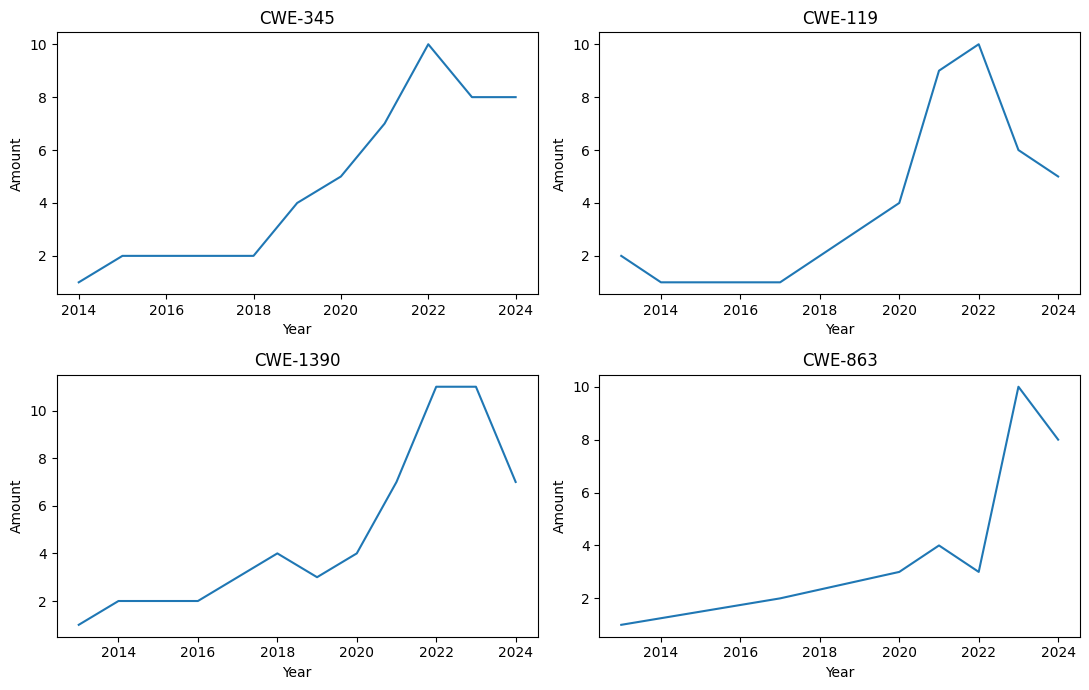

In [121]:
fig,axes = plt.subplots(nrows=2, ncols=2,figsize=(11, 7))

for idx, cwe_id in enumerate(possible_to_sample_cwes.select("cwe_id").to_series()):
    print(cwe_id)
    data = vulnerabilities_types_per_year.filter(pl.col("cwe_id") == cwe_id).to_pandas()
    ax = plt.subplot(2, 2, idx+1)
    ax.set_title(cwe_id)
    ax.set_xlabel("Year")
    ax.set_ylabel("Amount")
    ax.plot(data["year"], data["count"], label=cwe_id)
fig.tight_layout()

# data = {'apple': 10, 'orange': 15, 'lemon': 5, 'lime': 20}
# names = list(data.keys())
# values = list(data.values())

# fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharey=True)
# axs[0].bar(names, values)
# axs[1].scatter(names, values)
# axs[2].plot(names, values)
# fig.suptitle('Categorical Plotting')

In [73]:
code_unit_changes_df.explode("cwe_id").filter(pl.col("cwe_id") == "CWE-369").count()

shape: (1, 9)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ commit ‚îÜ repo ‚îÜ new_file ‚îÜ patch ‚îÜ ‚Ä¶ ‚îÜ vulnerability_id ‚îÜ cwe_id ‚îÜ old_file ‚îÜ code_unit_before_f ‚îÇ
‚îÇ ---    ‚îÜ ---  ‚îÜ ---      ‚îÜ ---   ‚îÜ   ‚îÜ ---              ‚îÜ ---    ‚îÜ ---      ‚îÜ ix                 ‚îÇ
‚îÇ u32    ‚îÜ u32  ‚îÜ u32      ‚îÜ u32   ‚îÜ   ‚îÜ u32              ‚îÜ u32    ‚îÜ u32      ‚îÜ ---                ‚îÇ
‚îÇ        ‚îÜ      ‚îÜ          ‚îÜ       ‚îÜ   ‚îÜ                  ‚îÜ        ‚îÜ          ‚îÜ u32                ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 11     ‚îÜ 11   ‚îÜ 11       ‚îÜ 11    ‚îÜ ‚Ä¶ ‚îÜ 11               ‚îÜ 11     ‚îÜ 11       ‚îÜ 11                 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

### Filter out rare cwes

In [118]:
cwes_to_exclude = clustered_cwes.select("cwe_id").explode("cwe_id").to_series().value_counts().sort("count", descending=True).filter(pl.col("count") < 100).select(pl.col("cwe_id")).to_series().to_list()
code_unit_without_rare_cwes = without_duplicates.explode("cwe_id").with_columns(pl.col("cwe_id").replace(VULNERABILITY_TYPES_MAPPING)).filter(pl.col("cwe_id").is_in(cwes_to_exclude).not_()).group_by("vulnerability_id").agg(pl.col("cwe_id"))
print(f"Amount of vulnerabilities without rare cwes: {code_unit_without_rare_cwes.shape[0]}")
print(f"Number of excluded vulnerabilities: {without_duplicates.unique("vulnerability_id").shape[0] - code_unit_without_rare_cwes.shape[0]}")

Amount of vulnerabilities without rare cwes: 1048
Number of excluded vulnerabilities: 597


In [74]:
code_unit_without_rare_cwes.describe()

shape: (9, 3)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ statistic  ‚îÜ vulnerability_id    ‚îÜ cwe_id ‚îÇ
‚îÇ ---        ‚îÜ ---                 ‚îÜ ---    ‚îÇ
‚îÇ str        ‚îÜ str                 ‚îÜ f64    ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ count      ‚îÜ 1025                ‚îÜ 1025.0 ‚îÇ
‚îÇ null_count ‚îÜ 0                   ‚îÜ 0.0    ‚îÇ
‚îÇ mean       ‚îÜ null                ‚îÜ null   ‚îÇ
‚îÇ std        ‚îÜ null                ‚îÜ null   ‚îÇ
‚îÇ min        ‚îÜ 2013-0212           ‚îÜ null   ‚îÇ
‚îÇ 25%        ‚îÜ null                ‚îÜ null   ‚îÇ
‚îÇ 50%        ‚îÜ null                ‚îÜ null   ‚îÇ
‚îÇ 75%        ‚îÜ null                ‚îÜ null   ‚îÇ
‚îÇ max        ‚îÜ GHSA-w228-rfpx-fhm4 ‚îÜ null   ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

In [109]:
code_unit_without_rare_cwes.unique("vulnerability_id")

shape: (1_048, 2)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ vulnerability_id    ‚îÜ cwe_id                          ‚îÇ
‚îÇ ---                 ‚îÜ ---                             ‚îÇ
‚îÇ str                 ‚îÜ list[str]                       ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 2018-14505          ‚îÜ ["CWE-20"]                      ‚îÇ
‚îÇ 2021-39371          ‚îÜ ["CWE-610", "CWE-610", ‚Ä¶ "CWE-‚Ä¶ ‚îÇ
‚îÇ 2023-25668          ‚îÜ ["CWE-119"]                     ‚îÇ
‚îÇ 2021-33503          ‚îÜ ["CWE-400"]                     ‚îÇ
‚îÇ 2019-7539           ‚îÜ ["CWE-74", "CWE-74", "CWE-74"]  ‚îÇ
‚îÇ ‚Ä¶                   ‚îÜ ‚Ä¶                               ‚îÇ
‚îÇ GHSA-vx3h-qwqw-r2wq ‚îÜ ["CWE-610"]                     ‚îÇ
‚îÇ 2023-47631          ‚îÜ ["CWE-345"]                     ‚îÇ
‚îÇ 2023-27494          ‚îÜ ["CWE-79", "CWE-79"]            ‚îÇ
‚îÇ 2023-45803          ‚îÜ ["CWE-200", "CWE-200", ‚Ä¶ "CWE-‚Ä¶ ‚îÇ
‚îÇ 2021-23727          ‚îÜ ["CWE-74", "CWE-74"]            ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

In [113]:
code_unit_without_rare_cwes.select("cwe_id").explode("cwe_id").unique()

shape: (11, 1)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ cwe_id   ‚îÇ
‚îÇ ---      ‚îÇ
‚îÇ str      ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ CWE-1390 ‚îÇ
‚îÇ CWE-74   ‚îÇ
‚îÇ CWE-200  ‚îÇ
‚îÇ CWE-610  ‚îÇ
‚îÇ CWE-79   ‚îÇ
‚îÇ ‚Ä¶        ‚îÇ
‚îÇ CWE-863  ‚îÇ
‚îÇ CWE-119  ‚îÇ
‚îÇ CWE-400  ‚îÇ
‚îÇ CWE-22   ‚îÇ
‚îÇ CWE-345  ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò